# MLZoomCamp Project 2023 #

## Overview 

This is the the notebook for the MLZoomcamp 2023 project.

It covers:
- Data preparation and data cleaning
- EDA, feature importance analysis
- Model selection process and parameter tuning

In [372]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data preparation and data cleaning
### Load Data ###

In [373]:
file_path  = './data/used-cars-prices-in-uk/used_cars_UK.csv'
if os.path.exists(file_path):
    print(f"The file {file_path} exists.")
else:
    # Get the link to the Kaggle dataset
    dataset_url = 'https://www.kaggle.com/datasets/muhammadawaistayyab/used-cars-prices-in-uk'
    # Download the dataset
    od.download(dataset_url, './data')

# read data into dataframe
df = pd.read_csv(file_path)
df.shape

The file ./data/used-cars-prices-in-uk/used_cars_UK.csv exists.


(3685, 14)

In [374]:
df.describe()

,Unnamed: 0,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats
count,3685.000000,3685.000000,3.685000e+03,3685.000000,2276.000000,3660.000000,3650.000000
mean,2314.770963,5787.145726,8.132816e+04,2011.835007,2.807557,4.321038,4.900274
std,1415.821308,4480.810572,3.942083e+04,5.092566,1.546028,0.986902,0.577200
min,0.000000,400.000000,1.000000e+00,1953.000000,1.000000,2.000000,2.000000
25%,1059.000000,2490.000000,5.698400e+04,2008.000000,2.000000,3.000000,5.000000
50%,2279.000000,4000.000000,8.000000e+04,2012.000000,3.000000,5.000000,5.000000
75%,3593.000000,7995.000000,1.030000e+05,2015.000000,4.000000,5.000000,5.000000
max,4727.000000,33900.000000,1.110100e+06,2023.000000,9.000000,5.000000,7.000000


### Prepare Data ###

In [375]:
df_bak = df.copy()

In [376]:
df.head()

,Unnamed: 0,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [377]:
# remove first column of dataframe
df = df.iloc[:, 1:]
df.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [378]:
# remove second column of dataframe
df = df.iloc[:, 1:]
df.head()

,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [379]:
# make all column headings lower case
df.columns = df.columns.str.lower()
df.head()

,price,mileage(miles),registration_year,previous owners,fuel type,body type,engine,gearbox,doors,seats,emission class,service history
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [380]:
# replace all ' ' (blanks) and '(' (open breackets#) with '_' (underscore) in all column headings
# remove any ')' (close brackets)
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('(', '_')
df.columns = df.columns.str.replace(')', '')
df.head()

,price,mileage_miles,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [381]:
# find columns with null
null_counts = df.isna().sum()
null_counts

price                   0
mileage_miles           0
registration_year       0
previous_owners      1409
fuel_type               0
body_type               0
engine                 45
gearbox                 0
doors                  25
seats                  35
emission_class         87
service_history      3145
dtype: int64

In [382]:
# find percentatge of service_history values that are null
(df.service_history.value_counts() / df.shape[0] * 100).round(2)

service_history
Full    14.65
Name: count, dtype: float64

In [383]:
# replace service_history null values with 'unk'
df['service_history'].fillna('unk', inplace=True)
df.head()

,price,mileage_miles,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,unk
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,unk
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,unk


In [384]:
df.previous_owners.value_counts()

previous_owners
2.0    594
1.0    523
3.0    475
4.0    360
5.0    208
6.0     60
7.0     39
8.0     12
9.0      5
Name: count, dtype: int64

In [385]:
# reeplace previous_owners null values with '0'
df['previous_owners'].fillna(0.0, inplace=True)
df.head()

,price,mileage_miles,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,unk
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,949,137000,2011,0.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,unk
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,1000,85000,2013,0.0,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,unk


In [386]:
df.head()

,price,mileage_miles,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,unk
1,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,949,137000,2011,0.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,unk
3,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,1000,85000,2013,0.0,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,unk


In [387]:
# remove rows where engine, gearbox, doors, seats or emission_class are null
df = df[~(df['engine'].isna() | df['gearbox'].isna() | df['doors'].isna() | df['seats'].isna() | df['emission_class'].isna())]
df.shape


(3591, 12)

In [388]:
# find columns with null
null_counts = df.isna().sum()
null_counts

price                0
mileage_miles        0
registration_year    0
previous_owners      0
fuel_type            0
body_type            0
engine               0
gearbox              0
doors                0
seats                0
emission_class       0
service_history      0
dtype: int64

In [389]:
df.describe().round()

,price,mileage_miles,registration_year,previous_owners,doors,seats
count,3591.0,3591.0,3591.0,3591.0,3591.0,3591.0
mean,5792.0,81511.0,2012.0,2.0,4.0,5.0
std,4515.0,39545.0,5.0,2.0,1.0,1.0
min,400.0,1.0,1993.0,0.0,2.0,2.0
25%,2490.0,56984.0,2008.0,0.0,3.0,5.0
50%,3999.0,80000.0,2012.0,1.0,5.0,5.0
75%,7999.0,103050.0,2016.0,3.0,5.0,5.0
max,33900.0,1110100.0,2023.0,9.0,5.0,7.0


In [390]:
df[df.mileage_miles > 200000]

,price,mileage_miles,registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
242,2600,234680,2011,1.0,Diesel,Estate,2.0L,Manual,5.0,5.0,Euro 5,unk
1035,2495,1110100,2003,4.0,Petrol,Hatchback,2.0L,Automatic,3.0,4.0,Euro 4,unk
1257,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk
1281,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk
1457,4769,207734,2012,0.0,Diesel,Saloon,3.0L,Automatic,4.0,5.0,Euro 6,unk
1476,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk
1683,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk
1931,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk
1944,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk
2046,795,274100,2004,6.0,Petrol,Estate,2.4L,Automatic,5.0,5.0,Euro 3,unk


**Check mileage for outliers**

<Axes: xlabel='mileage_miles', ylabel='Count'>

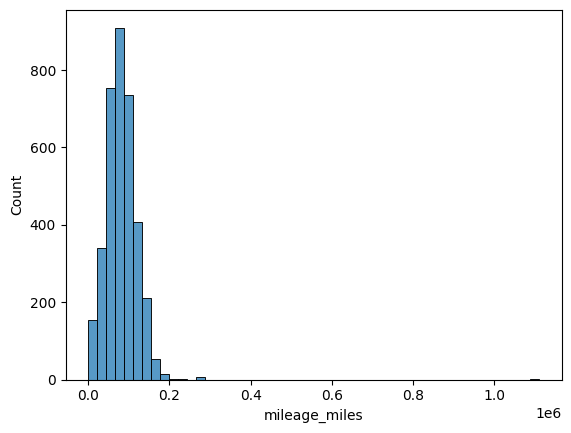

In [391]:
sns.histplot(df.mileage_miles, bins=50)

In [392]:
# remove cars with mileage >300,000 as these are probably data issues
df = df[df.mileage_miles < 300000]

<Axes: xlabel='mileage_miles', ylabel='Count'>

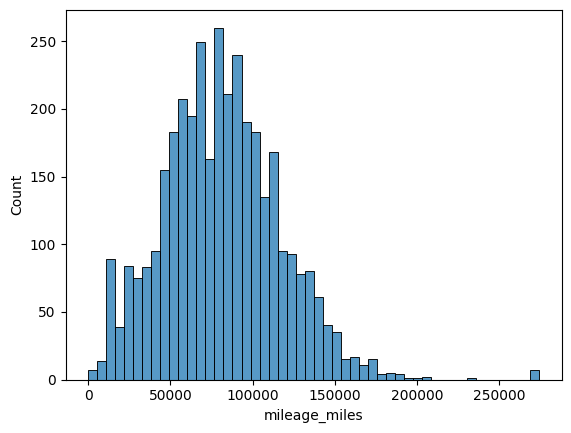

In [393]:
sns.histplot(df.mileage_miles, bins=50)

<Axes: xlabel='price', ylabel='Count'>

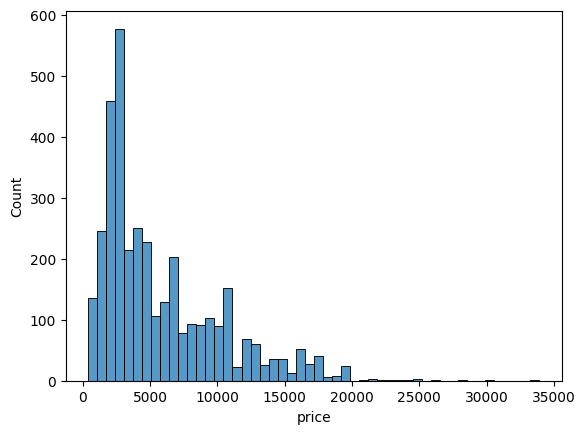

In [394]:
sns.histplot(df.price, bins=50)

In [395]:
# find all columns that have strings
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)
numerical.remove('price')

# replace blanks with '_' in columns that have strings
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [396]:
# add age and remove registration_year
df['age'] = 2023 - df['registration_year']
df = df.drop(columns=['registration_year'])
numerical.remove('registration_year')
numerical.append('age')
df.head()

,price,mileage_miles,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history,age
0,6900,70189,3.0,diesel,hatchback,1.4l,manual,5.0,5.0,euro_6,unk,7
1,1495,88585,4.0,petrol,hatchback,1.2l,manual,3.0,5.0,euro_4,full,15
2,949,137000,0.0,petrol,hatchback,1.4l,manual,5.0,5.0,euro_5,unk,12
3,2395,96731,5.0,petrol,hatchback,1.4l,manual,3.0,4.0,euro_4,full,13
4,1000,85000,0.0,diesel,hatchback,1.3l,manual,5.0,5.0,euro_5,unk,10


In [397]:
# move price column to end of dataframe
df = df[[col for col in df if col != 'price'] + ['price']]
df.head()

,mileage_miles,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history,age,price
0,70189,3.0,diesel,hatchback,1.4l,manual,5.0,5.0,euro_6,unk,7,6900
1,88585,4.0,petrol,hatchback,1.2l,manual,3.0,5.0,euro_4,full,15,1495
2,137000,0.0,petrol,hatchback,1.4l,manual,5.0,5.0,euro_5,unk,12,949
3,96731,5.0,petrol,hatchback,1.4l,manual,3.0,4.0,euro_4,full,13,2395
4,85000,0.0,diesel,hatchback,1.3l,manual,5.0,5.0,euro_5,unk,10,1000


In [398]:
# make back-up copy of dataframe
df_bak = df.copy()
df_bak.head()

,mileage_miles,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history,age,price
0,70189,3.0,diesel,hatchback,1.4l,manual,5.0,5.0,euro_6,unk,7,6900
1,88585,4.0,petrol,hatchback,1.2l,manual,3.0,5.0,euro_4,full,15,1495
2,137000,0.0,petrol,hatchback,1.4l,manual,5.0,5.0,euro_5,unk,12,949
3,96731,5.0,petrol,hatchback,1.4l,manual,3.0,4.0,euro_4,full,13,2395
4,85000,0.0,diesel,hatchback,1.3l,manual,5.0,5.0,euro_5,unk,10,1000


## Exploratory Data Analysis ##

Used Car Prices in UK Dataset is a comprehensive collection of automotive information extracted from the popular automotive marketplace website, autotrader.co.uk. This dataset comprises 3,685 data points, each representing a unique vehicle listing, and includes thirteen distinct features providing valuable insights into the world of automobiles. 

The feature names are:
- title
- Price : price of car in pounds
- Mileage(miles)
- Registration(year)
- Previous Owners
- Fuel Type
- Body Type
- Engine
- Gearbox
- Seats
- Doors
- Emission Class
- Service history

In [399]:
# find unique values and show first 5
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()


mileage_miles
[ 70189  88585 137000  96731  85000]
1537

previous_owners
[3. 4. 0. 5. 1.]
10

fuel_type
['diesel' 'petrol' 'petrol_plug-in_hybrid' 'petrol_hybrid' 'diesel_hybrid']
5

body_type
['hatchback' 'coupe' 'saloon' 'convertible' 'estate']
9

engine
['1.4l' '1.2l' '1.3l' '2.0l' '1.6l']
34

gearbox
['manual' 'automatic']
2

doors
[5. 3. 4. 2.]
4

seats
[5. 4. 2. 7. 3.]
6

emission_class
['euro_6' 'euro_4' 'euro_5' 'euro_3' 'euro_2']
6

service_history
['unk' 'full']
2

age
[ 7 15 12 13 10]
28

price
[6900 1495  949 2395 1000]
861



### Feature Importance ###

In [400]:
numerical

['mileage_miles', 'previous_owners', 'doors', 'seats', 'age']

In [401]:
def mutual_info_price_score(series):
    return mutual_info_score(series, df.price)

In [402]:
mi = df[categorical].apply(mutual_info_price_score)
mi.sort_values(ascending=False)

engine             1.261823
emission_class     0.767222
body_type          0.649060
fuel_type          0.352529
gearbox            0.220557
service_history    0.192319
dtype: float64

In [403]:
numerical

['mileage_miles', 'previous_owners', 'doors', 'seats', 'age']

In [404]:

df[numerical].corrwith(df.price).abs()

mileage_miles      0.552908
previous_owners    0.228897
doors              0.113371
seats              0.025281
age                0.785983
dtype: float64

### Split data ###

In [405]:
# split data into train/validation/test split with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [406]:
# reset indeces
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [407]:
# set target value
y_train = df_train.price
y_val = df_val.price
y_test = df_test.price

In [408]:
del df_train['price']
del df_val['price']
del df_test['price']

In [409]:
print('df_train: ', df_train.shape)
print('df_val: ', df_val.shape)
print('df_test: ', df_test.shape)

df_train:  (2154, 11)
df_val:  (718, 11)
df_test:  (718, 11)


In [410]:
# backup dataframes
df_train_bak = df_train.copy()
df_val_bak = df_val.copy()
df_test_bak = df_test.copy()

## Train Models ##
### 1. Linear Regression Model ##

In [411]:
def train(df_train, y_train):
    # set-up input for model
    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)

    # create a LinearRegression model
    model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)

    # fit the training data
    model.fit(X_train, y_train)

    return dv, model

In [412]:
def predict(df, dv, model):
    # predict using the validation data
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)[0]

    return y_pred

In [413]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [414]:
y_pred

4251.231084767594

In [415]:
# save linear regression model to pickle file
output_file = f'model_reg.bin'
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

In [416]:
# train model on train and val data
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [417]:
# Create a LinearRegression model
model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the validation data
y_pred = pd.Series(model.predict(X_val))

# Calculate the Mean Squared Error on the validation data
linear_mse = mean_squared_error(y_val, y_pred)

print(f"Mean Squared Error on for the Linear Regression model: {linear_mse:.3f}")

Mean Squared Error on for the Linear Regression model: 3115864.267


In [418]:
print(f"Model score: {model.score(X_val, y_val):.3f}")

Model score: 0.852


<Axes: xlabel='price', ylabel='Count'>

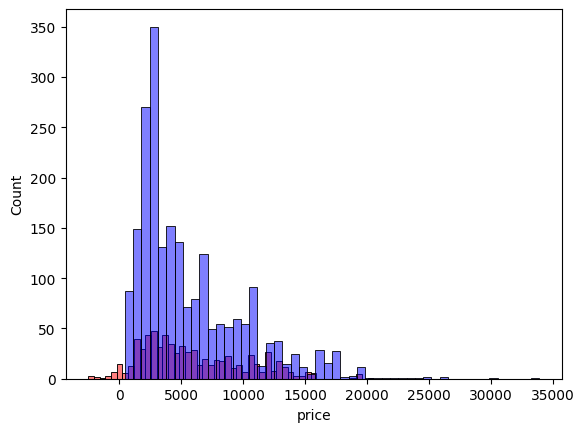

In [419]:
# graphically compare predicted values to actual values 
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

### 2. Decision Trees Model ###

In [420]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [421]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [422]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [423]:
y_pred = dt.predict(X_val)

# Calculate the Mean Squared Error on the validation data
mse = mean_squared_error(y_val, y_pred)

print(f"Mean Squared Error on Validation Data: {mse:.3f}")

Mean Squared Error on Validation Data: 5652978.215


### Decision trees parameter tuning ###

In [424]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, mse))

   1 -> 8627985.387
   2 -> 6202743.405
   3 -> 4452413.822
   4 -> 5400013.271
   5 -> 4984495.277
   6 -> 4545334.142
  10 -> 4880940.361
  15 -> 5450863.101
  20 -> 5717854.447
None -> 5649275.269


best depth = 3

In [425]:
scores = []

for depth in [3, 4, 5, 6, 7, 8]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        
        scores.append((depth, s, mse))

In [426]:
columns = ['max_depth', 'min_samples_leaf', 'mse']
df_scores = pd.DataFrame(scores, columns=columns)

In [427]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['mse'])
df_scores_pivot.round(3)

mse                                         \
max_depth                   3            4            5            6   
min_samples_leaf                                                       
1                 4452413.822  5400013.271  4984495.277  4540083.557   
5                 4452413.822  3719725.103  3287241.935  2993134.128   
10                4452413.822  3767569.944  3259517.829  3011084.750   
15                4452413.822  3765750.710  3253510.091  3006663.176   
20                4452413.822  3719420.451  3281399.880  3054471.104   
100               5586133.855  5393303.008  5357591.164  5357401.753   
200               5828765.440  5745501.529  5739993.247  5739993.247   
500               7317263.630  7317263.630  7317263.630  7317263.630   

                                            
max_depth                   7            8  
min_samples_leaf                            
1                 4787148.133  4624927.511  
5                 3061141.485  2898774.747  
10                2867828.468  2902992.047  
15                2915328.487  2860440.023  
20                2950740.400  2887825.779  
100               5355420.700  5355420.700  
200               5739993.247  5753701.871  
500               7317263.630  7317263.630

best max_depth = 6 and min_sammples_leaf = 10

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

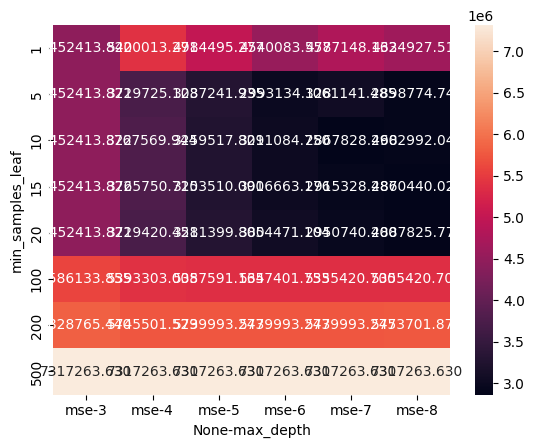

In [428]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [429]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

# Calculate the Mean Squared Error on the validation data
tree_mse = mean_squared_error(y_val, y_pred)

print(f"Mean Squared Error on for the Decision Tree model: {tree_mse:.3f}")


Mean Squared Error on for the Decision Tree model: 3011084.750


### 3. XGBoost Model ###

In [431]:
features_array = dv.get_feature_names_out()
features = [str(item) for item in features_array]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [432]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [456]:
y_pred = model.predict(dval)


# Calculate the Mean Squared Error on the validation data
mse = mean_squared_error(y_val, y_pred)

print(f"Mean Squared Error on Validation Data: {mse:.3f}")

Mean Squared Error on Validation Data: 2187240.626


### XGBoost Parameter Tuning ###

Tuning the following parameters:
- eta
- max_depth
- min_child_weight

In [434]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_mse', 'val_mse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [435]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [436]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'loss': 'squared_error',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [437]:
scores = {}

In [438]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [439]:
scores = {}

In [440]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'loss': 'squared_error',


    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [441]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

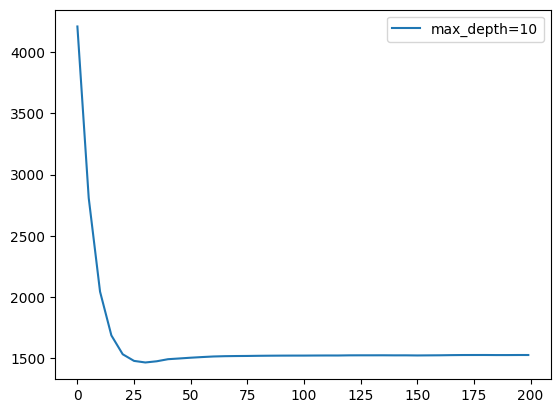

In [442]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_mse, label=max_depth)

plt.legend()

In [443]:
scores = {}

In [444]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'reg:squarederror',
    'loss': 'squared_error',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [445]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

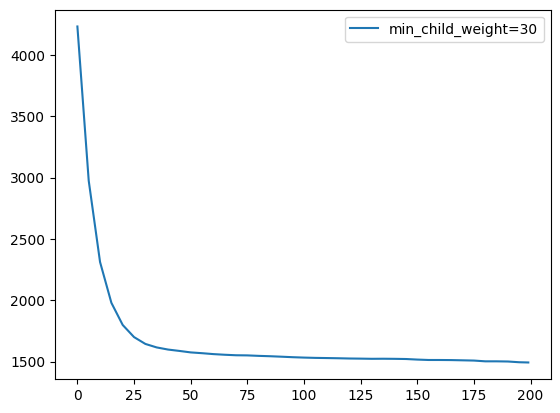

In [446]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_mse, label=min_child_weight)

plt.legend()

In [447]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 30,

    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [448]:
y_pred = model.predict(dval)

# Calculate the Mean Squared Error on the validation data
xgb_mse = mean_squared_error(y_val, y_pred)

print(f"Mean Squared Error on for the XGBoost model: {xgb_mse:.3f}")

Mean Squared Error on for the XGBoost model: 2187240.626


## Selecting the final model ##
- Choosing between linear regression, decision tree and XGBoost
- Training the final model
- Saving the model

In [449]:
print(f"Mean Squared Error on for the Linear Regression model: {linear_mse:.3f}")
print(f"Mean Squared Error on for the Decision Tree model: {tree_mse:.3f}")
print(f"Mean Squared Error on for the XGBoost model: {xgb_mse:.3f}")


Mean Squared Error on for the Linear Regression model: 3115864.267
Mean Squared Error on for the XGBoost model: 2187240.626
Mean Squared Error on for the Decision Tree model: 3011084.750


In [450]:
print('The winner is the XGBoost model')

The winner is the XGBoost model


In [451]:
# no need to retrain as the last model we trained was the XGBoost model with the best parameters

# save linear regression model to pickle file
output_file = f'model_xgb.bin'
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

3645